# Foundations of Data Mining: Assignment 3
Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

##### Group 36:  
Suraj Iyer (0866094)  
Kevin Eenige (0862649)

In [7]:
%matplotlib inline
from preamble import *
import numpy as np
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "none"
_ = plt.rc('grid', linestyle="--", alpha=0.3)

##  Random Projections with 1-NN (6 points, 3+3)

Implement random projections for dimensionality reduction as follows.
Randomly generate a $k \times d$ matrix $\bf R$ by choosing its coefficients
$$
r_{i,j}=
\begin{cases}
+\frac{1}{{\sqrt{d}}} \quad \text{with probability}\quad &\frac{1}{2}\\
-\frac{1}{\sqrt{d}} \quad \text{with probability} \quad & \frac{1}{2}
\end{cases}
$$ 
Let $f:\mathbb{R}^d \rightarrow \mathbb{R}^k$ denote the linear mapping function that 
multiplies a $d$-dimensional vector with this matrix $f(p)={\bf R}p$.
For the following exercises use the same data set as was used for Assignment 1 (MNIST). 
Use the following values of $k=45,90,400$ in your experiments.  
You should _not_ use sklearn.random_projection for this assignment.


###  Study the effect on pairwise distances
Evaluate how well the Euclidean distance is preserved by plotting a histogram of the 
values $\phi(p,q) = \frac{\|f(p)-f(q)\|}{\|p-q\|}$ for all pairs of the first 500 images of the MNIST data set. These values should be concentrated around a certain value for fixed $k$. What is this value expressed in terms of $k$ and $d$? Explain your answer.


In [8]:
# This is a temporary read-only OpenML key. Replace with your own key later. 
oml.config.apikey = '11e82c8d91c5abece86f424369c71590'

In [13]:
mnist_data = oml.datasets.get_dataset(554) # Download MNIST data
# Get the predictors X and the labels y
X, y = mnist_data.get_data(target=mnist_data.default_target_attribute)
K = [45, 90, 400]
d = X.shape[1]

In [10]:
# Randomly sample with probability 1/2
print(np.random.randint(0,2))

0


In [35]:
def rij(d):
    rij = np.sqrt(1/d)
    return rij if np.random.randint(0,2) == 0 else -rij

def projection_matrix(k, d):
    return np.matrix([[rij(d) for j in range(0, d)] for i in range(0, k)])

def rp_transform(X, R):
    X_new = []
    for x in X:
        X_new.append(np.dot(R, x).A1)
    X_new = np.array(X_new)
    return X_new

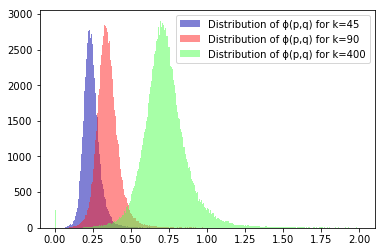

In [235]:
for i, k in enumerate(K):
    # Get transformed X
    R = projection_matrix(k, d)
    X_new = rp_transform(X[:500], R)
    assert X_new.shape[1] == k
    
    # Calculate phi
    phi = []
    for p, x1 in enumerate(X_new):
        for q, x2 in enumerate(X_new[p+1:]):
            new_dist = np.linalg.norm(x1 - x2)
            old_dist = np.linalg.norm(X[p] - X[q])
            phi.append(new_dist/old_dist if old_dist != 0 else 0)
    phi = np.array(phi)
    
    # plot phi as histogram
    _ = plt.hist(phi, bins="auto", alpha=0.5, range=[0, 2], label="Distribution of ϕ(p,q) for k=%d" % k)
    _ = plt.legend()

$\phi(p,q) = \frac{\|f(p)-f(q)\|}{\|p-q\|}$ is the ratio of the euclidean distance between two images $p$ and $q$ in $k$-dimensional space and $d$-dimensional space. As $k$ increases, the euclidean distance between two images also increases because for increasing $k$, the histogram shifts more to the right.

### Study the effect on classification
Compare the performance of a $1$-NN classifier with and without random projection. Report multi-class confusion matrix, precision and recall for each class with and without projection and for each value of $k$. Evaluate your findings with respect to the use of random projections and classification.

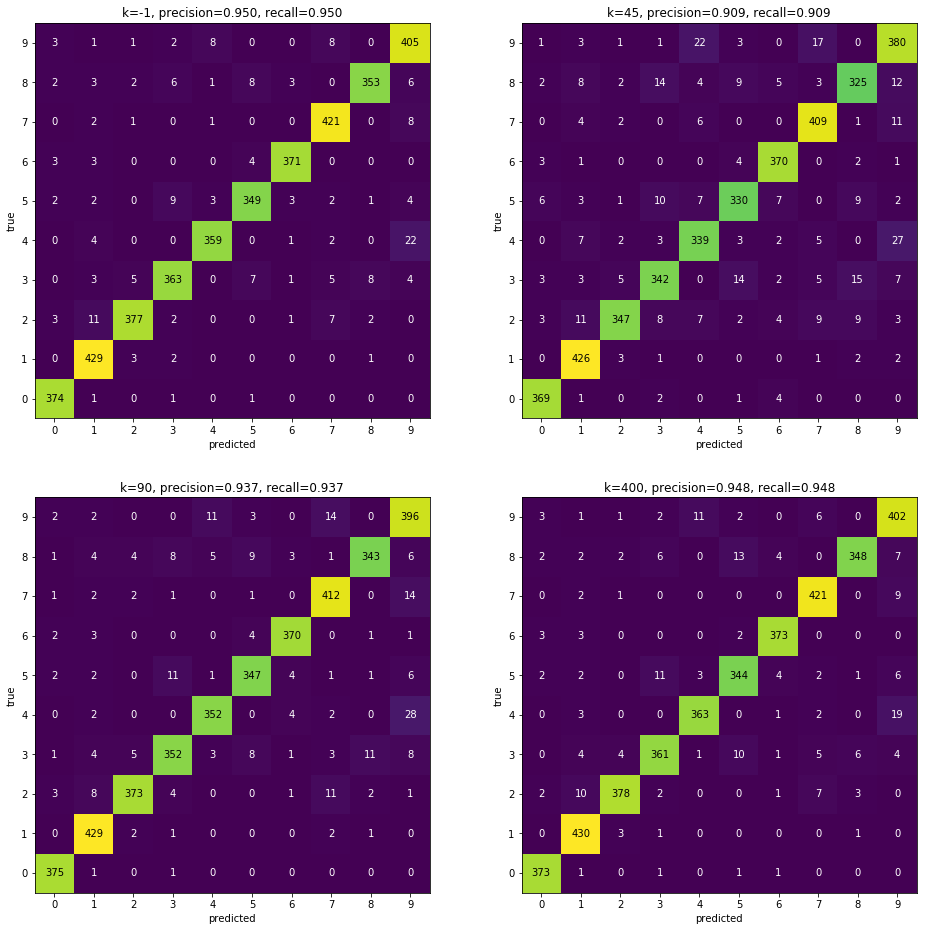

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Split the data
_X, _y = X[:16000], y[:16000]
X_train, X_test, y_train, y_test = train_test_split(_X, _y)

# Build plots
fig = plt.figure(figsize=(16, 16))

# Get the number of unique labels
labels = np.unique(y)

# Get the number of original features
d = X.shape[1]

# knn classifier with 1 neighbor
clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

for i, k in enumerate([-1]+K):
    if k == -1:
        # No transformation
        X_train_new, X_test_new = X_train, X_test
    else:
        # Get transformed X
        R = projection_matrix(k, d)
        X_train_new, X_test_new = rp_transform(X_train, R), rp_transform(X_test, R)
        assert X_train_new.shape[1] == k and X_test_new.shape[1] == k
    
    # Fit the model
    clf.fit(X_train_new, y_train)
    y_pred = clf.predict(X_test_new)
    
    # Get the scores
    confusion = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="micro")
    recall = recall_score(y_test, y_pred, average="micro")
    
    # Plot the scores
    ax = fig.add_subplot(221+i)
    ax.set_title('k=%d, precision=%.3f, recall=%.3f' % (k, precision, recall))
    mglearn.tools.heatmap(confusion, ax=ax, cmap="viridis", fmt="%d",
                          xlabel='predicted', xticklabels=labels, 
                          ylabel='true', yticklabels=labels)

Evaluation: The 1-NN classifier without random projection (k=-1) has better recall and precision score than with random projection for any $k$. With random projection, the trend is that the 1-NN classifier performs better with increasing $k$ from recall, precision and the confusion matrix values. Our final verdict is that this classifier performs better with increasing set of features.

## PCA of a handwritten digits (7 points, 3+2+2)
Analyze the first two principal components of the class with label $4$ of the MNIST data set (those are images that each depict a handwritten "4"). Perfom the steps (a), (b), (c) described below. Note that these steps are similar to the analysis given in the lecture. Include all images and plots in your report. You may use sklearn.decomposition.PCA for this assignment. Do not scale the data.

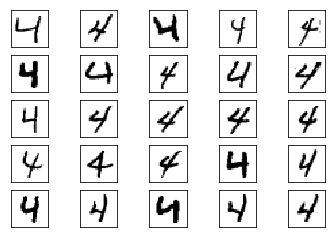

In [54]:
# build a list of figures on a 5x5 grid for plotting
def buildFigure5x5(fig, subfiglist):
    for i in range(0,25):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a=fig.add_subplot(5,5,i+1)
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

# find the first 25 instances with label '4' and plot them
imgs = np.empty([25, 28*28], dtype='float')
j=0
for i in range(0,len(X)):
    if(y[i] == 4) and j < 25:
        imgs[j] = np.array(X[i], dtype='float')
        j += 1

buildFigure5x5(plt.figure(1), imgs)
plt.show()

### Step (a)
 Generate a scatter plot of the data in the space spanned by the first two principal components of PCA. Reconstruct $25$ points on a $5 \times 5$ grid in this space that cover the variation of the data. Render each point as an image. Arrange the images in a $5 \times 5$ grid.


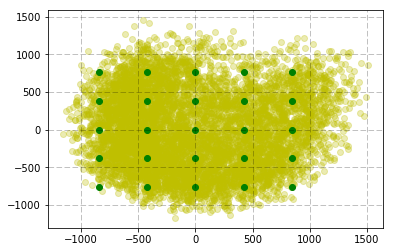

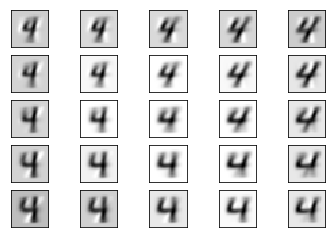

In [204]:
from sklearn.decomposition import PCA

# Compute the transformed images
pca = PCA(n_components=2, random_state=66)
imgs_4 = X[y==4]
imgs_4_new = pca.fit_transform(imgs_4)

# Compute the grid points
mean, std = np.mean(imgs_4_new, axis=0), np.std(imgs_4_new, axis=0)
_min, _max = mean - 1.5*std, mean + 1.5*std

grid_x = np.arange(_min[0], _max[0]+1, (_max[0] - _min[0])/4)
grid_y = np.arange(_min[1], _max[1]+1, (_max[1] - _min[1])/4)
grid = np.array([[x, y] for x in grid_x for y in grid_y])
grid_new = pca.inverse_transform(grid)

# Build plots
_ = plt.scatter(*imgs_4_new.T, color='y', alpha=0.3)
_ = plt.scatter(*grid.T, color='g')
_ = plt.grid()
plt.show()

buildFigure5x5(plt.figure(1), grid_new)
plt.show()

### Step (b) 
For each of the reconstructed points, find the original instance that is closest to it in the projection on the first two components (measured using Euclidean distance). Render the instances arranged in a $5 \times 5$ grid such that their position matches the rendering in (a).


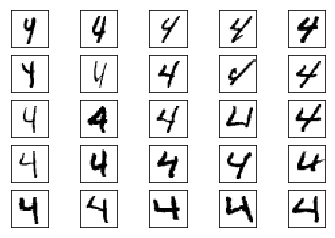

In [216]:
closest_points = []
for p in grid:
    # Find the euclidean distance between all original 
    # points and the grid point in the transformed space 
    dist = np.apply_along_axis(np.linalg.norm, 1, imgs_4_new-p)
    
    # Take the point with the least distance
    closest_points.append(imgs_4[np.argmin(dist)])
    
# Plot the points as images
buildFigure5x5(plt.figure(1), closest_points)

### Step (c)
Render the mean and the first two principal components as images. What is your interpretation of the first two components, i.e., which aspect of the data do they capture? Justify your interpretation, also using your results of Steps (a) and (b).


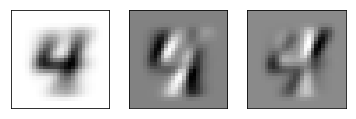

In [227]:
def buildFigure1x3(fig, subfiglist):
    for i in range(0, 3):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a=fig.add_subplot(1,3,i+1)
        imgplot = plt.imshow(pixels, cmap='gray_r')
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

buildFigure1x3(plt.figure(1), [pca.mean_, *pca.components_])

The images are given in the order: Mean, PC1 and PC2. PC1 captures the general size of the digit in the image. In both the previous steps, we can see that as you move diagonally from the top-left to the bottom-right, the size of the digit seems to increase. PC2 covers the slanting of the number which is evident from the picture of the component itself. We also notice this in the images of the previous steps. As you go from left to right, the digit generally becomes more slanted to the right. There are a few exceptions to this on the last row especially the second one from the right (24th image) which is slanted to the left.

## Projection onto a hyperplane (4 points)
Let $F$ be a $k$-dimensional hyperplane given by the parametric representation
$$ g(\lambda) = \mu + {\bf V} \lambda,$$
where $\mu \in \mathbb{R}^d$ and the columns of $\bf V$ are pairwise orthogonal and unit vectors $\bf v_1,\dots,\bf v_k \in \mathbb{R}^d$.
Let $f:\mathbb{R}^d\rightarrow F$ be the projection that maps every point ${\bf p} \in \mathbb{R}^d$ to its nearest point on $F$ (where distances are measured using the Euclidean distance). We can write the projection into the subspace spanned by $\bf v_1,\dots,\bf v_k$ as follows 
$$f({\bf p}) = {\bf V}^T ({\bf p}-\mu).$$

Prove that for any ${\bf p,\bf q} \in \mathbb{R}^d$, it holds that
$$ \|f({\bf p})-f({\bf q})\| \leq \|{\bf p-\bf q}\|. $$

(Hint: Assume first that $\mu=0$. Rewrite $f$ using a rotation followed by an orthogonal projection. What happens to the distance in each step? Generalize to arbitrary $\mu$.)


#### Answer

Let $\mu=0$, then 
$$f({\bf p}) = {\bf V}^T ({\bf p}-0) = {\bf V}^T {\bf p}.$$

Then we rewrite $f$ using a rotation $R$ followed by an orthogonal projection $P$, which gives:

$$f({\bf p}) = P(R({\bf p})).$$

If we then substitute this in the formula for the euclidean distance, we get:

$$ \|f({\bf p})-f({\bf q})\| = \|P(R({\bf p}))-P(R({\bf q}))\| = \|P(R({\bf p - q}))\|. $$

As ${\bf p}$ and ${\bf q}$ are points, their difference can be substituted with ${\bf v} = {\bf p - q}$

$$ \|P(R({\bf p - q}))\| = \|P(R({\bf v}))\|. $$

As per definition of a rotation matrix $R$, we know that the length of any vector is preserved under $R$, thus it does not influence the distance:

$$ \|P(R({\bf v}))\| = \|P({\bf v})\|. $$

Since $P$ is an orthogonal projection onto the first $k$ coordinates and $k \leq  d$ and we know that the length of the projected vector will be lesser or equal to the original length.

$$ \|P({\bf v})\| \leq \|{\bf v}\| = \|{\bf p - \bf q}\|. $$

Now, by taking an arbitrary $\mu$, we can substitute the corresponding ${\bf p}-\mu$ and the previous reasonings still hold.

## Locality-sensitive hashing (3 points, 1+2)

$H$ is a family of $(d_1,d_2,p_1,p_2)$-locality-sensitive hash functions if it holds that
\begin{align}
\text{if}\quad d({\bf p,\bf q})\leq d_1 \quad &\text{then}& \quad \Pr\left[ h({\bf p})=h({\bf q})\right] \geq p_1 \quad \\
\text{if}\quad d({\bf p,\bf q})\geq d_2 \quad &\text{then}& \quad \Pr\left[ h({\bf p})=h({\bf q})\right] \leq p_2 \quad
\end{align}

### Case: $p_2=0$
Assume that $p_2=0$ and assume we have a total numer of $m$ hash
functions from this family available.  Which combination of AND-constructions
and OR-constructions should we use to amplify the hash family?



We are given a family of $m$ hash function: $H$. We need to construct a new family of functions that amplify the success probability: $H'$. We know AND-construction yields $(d_1, d_2, p_1^r, p_2^r)$-sensitive family and OR-construction yields $(d_1, d_2, 1-(1-p_1)^L, 1-(1-p_2)^L)$-sensitive family.

Let us consider compositions of AND and OR constructions. Since $p_2 = 0$, $p_2^r = 0$ for any $r \geq 0$ and $1-(1-p_2)^L = 0$ for any $L \geq 0$. So we only care about maximizing $p_1$. Thus an AND-OR composition yields $(d_1, d_2, 1-(1-p_1^r)^L, 0)$-sensitive family while an OR-AND composition yields $(d_1, d_2, (1-(1-p_1)^L)^r, 0)$-sensitive family where $L \cdot r=m$. We need to tune $L$ and $r$ such that they increase $p_1$. But we can see that in both cases, setting $L=m$ and $r=1$ yields the maximum $p_1$ value. But this is the same as a simple OR-construction without any composition. Therefore, using just OR-construction without an AND-construction is the best choice here.

For all other combinations of $L$ and $r$ such that $L \cdot r = m$, it is better to use OR-AND combination because $p_1$ monotonically increases faster than with the AND-OR combination we found by testing on multiple combinations of $L$ and $r$.

### Case: $p_2=\frac{1}{n}$
Now assume that $p_2=\frac{1}{n}$ and assume we have $n$ data points $\bf P$
which are stored in a hash table using a randomly chosen function $h$ from $H$.
Given a query point $\bf q$, we retrieve the points in the hash bucket with index $h(\bf q)$ to search 
for a point which has small distance to $\bf q$. 
Let $X$ be a random variable that is equal to the size of the set 

\begin{align}
\left\{{\bf p \in P}\,:\, h({\bf p})=h({\bf q}) \,\wedge\, d({\bf p,\bf q}) \geq d_2\right\}\
\end{align}

which consists of the false positives of this query.

Derive an upper bound on the expected number of false-positives $\mathbb{E}\left[ X \right]$ using $p_2$. Explain each step of your derivation.

First, we derive $P[h({\bf p})=h({\bf q}) \,|\, d({\bf p,\bf q}) \geq d_2]$, i.e. the probability of a false positive. So, given a query point $\bf q$, we can assume $d({\bf p,\bf q}) \geq d_2 \, \forall \bf p \in P$.

\begin{align*}
    &P[h({\bf p})=h({\bf q}) \,|\, d({\bf p,\bf q}) \geq d_2]\\
    &\leq p2 & \text{(Given)}\\
    &= \frac{1}{n} & \text{(Given)}
\end{align*}

Now in the worst case, there are total $n$ slots to hash into and hashing is independent which implies $E[X]=n \cdot P[h({\bf p})=h({\bf q}) \,|\, d({\bf p,\bf q}) \geq d_2] \leq n \cdot \frac{1}{n} = 1$.